In [6]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [7]:
import glob

BASE_DIR = "/kaggle/input/data"
CSV_PATH = os.path.join(BASE_DIR, "Data_Entry_2017.csv")

# Find all images inside "image_001/images/" to "image_012/images/"
IMAGE_DIRS = [os.path.join(BASE_DIR, f"images_{str(i).zfill(3)}/images") for i in range(1, 13)]
IMAGE_FILES = {os.path.basename(f): f for d in IMAGE_DIRS for f in glob.glob(os.path.join(d, "*.png"))}

# Check if images were found
print(f"Total images found: {len(IMAGE_FILES)}")


Total images found: 112120


In [8]:
import pandas as pd

# Load the dataset
df = pd.read_csv(CSV_PATH)

# Keep only relevant columns
df = df[['Image Index', 'Finding Labels']]

# Convert multi-labels into lists
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

# List of all 14 diseases
diseases = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule',
    'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis',
    'Pleural_Thickening', 'Hernia'
]

# Create one-hot encoded labels for all 14 diseases
for disease in diseases:
    df[disease] = df['Finding Labels'].apply(lambda x: 1 if disease in x else 0)

# Drop the original 'Finding Labels' column
df.drop(columns=['Finding Labels'], inplace=True)

# Check label distribution
print(df[diseases].sum())

# Show first few rows
df.head()


Atelectasis           11559
Cardiomegaly           2776
Effusion              13317
Infiltration          19894
Mass                   5782
Nodule                 6331
Pneumonia              1431
Pneumothorax           5302
Consolidation          4667
Edema                  2303
Emphysema              2516
Fibrosis               1686
Pleural_Thickening     3385
Hernia                  227
dtype: int64


,Image Index,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,00000001_002.png,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [9]:
# Get the unique labels (disease names) from the column names
unique_labels = list(diseases)  # 'diseases' is the predefined list of 14 diseases
print(unique_labels)  # Check what labels exist in the dataset


['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']


In [10]:
# Check the distribution of each disease (number of positive cases)
print(df[diseases].sum())


Atelectasis           11559
Cardiomegaly           2776
Effusion              13317
Infiltration          19894
Mass                   5782
Nodule                 6331
Pneumonia              1431
Pneumothorax           5302
Consolidation          4667
Edema                  2303
Emphysema              2516
Fibrosis               1686
Pleural_Thickening     3385
Hernia                  227
dtype: int64


In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Features (image filenames) and multi-label targets (one-hot encoded)
X = df['Image Index'].values  # Image file names
y = df[diseases].values  # Multi-label (14 disease columns)

# Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train-Validation Split (10% of Train)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

# Print dataset distribution
print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")


Train: 80726, Validation: 8970, Test: 22424


In [12]:
# Load CSV and keep only relevant columns
df = pd.read_csv(CSV_PATH)
df = df[['Image Index', 'Finding Labels']]

# Convert multi-labels into lists
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

# Define all 14 disease labels
diseases = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule',
    'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis',
    'Pleural_Thickening', 'Hernia'
]

# Create one-hot encoded columns for each disease (multi-label classification)
for disease in diseases:
    df[disease] = df['Finding Labels'].apply(lambda x: 1 if disease in x else 0)

# Map filenames from IMAGE_FILES dictionary
df.loc[:, 'filename'] = df['Image Index'].map(IMAGE_FILES)

# Remove missing files (NaN filenames)
df = df.dropna()

print(f"Images available after filtering: {len(df)}")
df.head()


Images available after filtering: 112120


,Image Index,Finding Labels,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia,filename
0,00000001_000.png,[Cardiomegaly],0,1,0,0,0,0,0,0,0,0,0,0,0,0,/kaggle/input/data/images_001/images/00000001_...
1,00000001_001.png,"[Cardiomegaly, Emphysema]",0,1,0,0,0,0,0,0,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_...
2,00000001_002.png,"[Cardiomegaly, Effusion]",0,1,1,0,0,0,0,0,0,0,0,0,0,0,/kaggle/input/data/images_001/images/00000001_...
3,00000002_000.png,[No Finding],0,0,0,0,0,0,0,0,0,0,0,0,0,0,/kaggle/input/data/images_001/images/00000002_...
4,00000003_000.png,[Hernia],0,0,0,0,0,0,0,0,0,0,0,0,0,1,/kaggle/input/data/images_001/images/00000003_...


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Train-Test Split (80% Train, 20% Test) - Stratify using multi-labels
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Train-Validation Split (10% of Train)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

BATCH_SIZE = 16
IMG_SIZE = (224, 224)

# Image augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.1, horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load images with updated multi-label one-hot encoded y-values
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',  # Image file paths
    y_col=diseases,  # Multi-label one-hot encoding
    directory=None,  
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw"  # Raw for multi-label classification
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename', 
    y_col=diseases,  
    directory=None,  
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="raw"
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename', 
    y_col=diseases,  
    directory=None,  
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="raw", 
    shuffle=False
)

print(f"Train: {len(train_generator)}, Validation: {len(val_generator)}, Test: {len(test_generator)}")


Found 80726 validated image filenames.
Found 8970 validated image filenames.
Found 22424 validated image filenames.
Train: 5046, Validation: 561, Test: 1402


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    # Multi-label classification (14 outputs with sigmoid activation)
    Dense(14, activation='sigmoid')
])

# Compile model for multi-label classification
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',  # Per-label binary cross-entropy
              metrics=['accuracy'])  # Consider adding AUC for better evaluation

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │           1,806 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,766 (42.61 MB)

 Trainable params: 11,170,766 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

EPOCHS = 5  # Adjust based on performance

# Callbacks to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)  # Save entire model

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/5
 115/5046 ━━━━━━━━━━━━━━━━━━━━ 1:49:34 1s/step - accuracy: 0.1748 - loss: 0.2762

In [12]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")


50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 581ms/step - accuracy: 0.6636 - loss: 0.6292
Test Accuracy: 0.6599


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


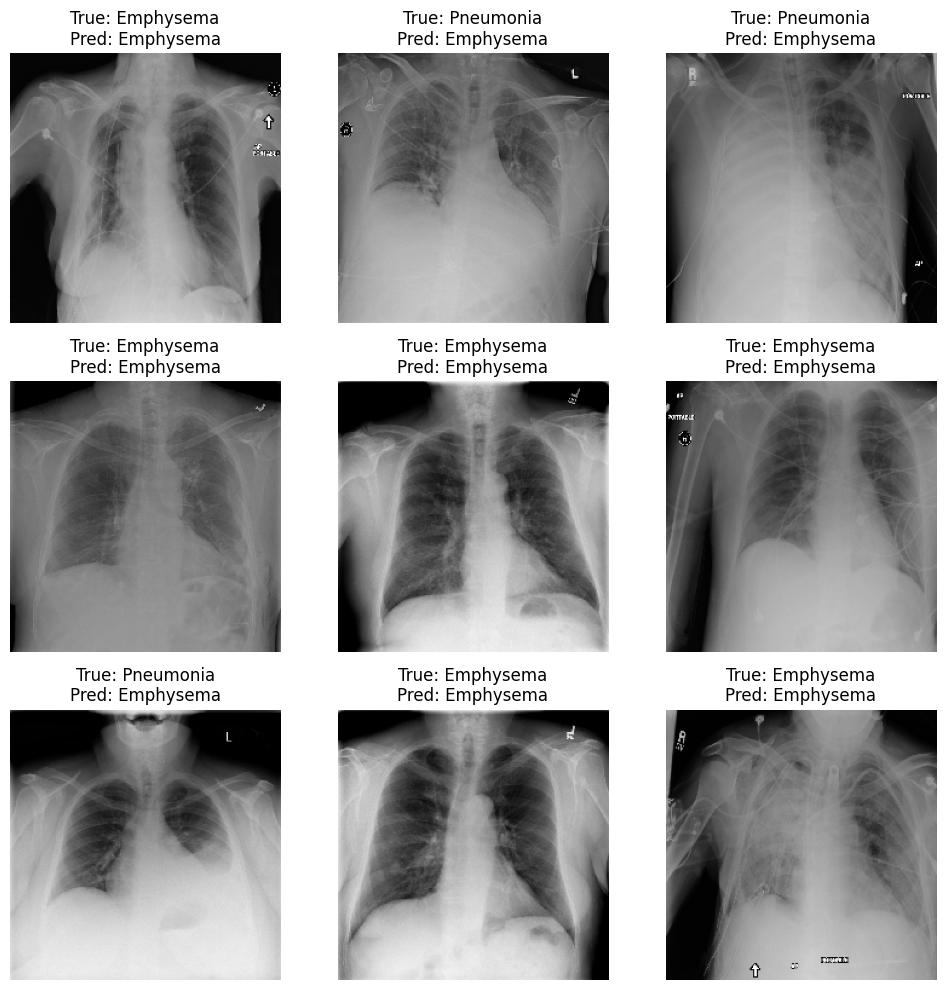

In [13]:
import random

# Select random test images
sample_images, sample_labels = next(test_generator)
predictions = model.predict(sample_images)

# Plot images with predictions
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i in range(9):
    img = sample_images[i]
    true_label = "Pneumonia" if sample_labels[i] == 1 else "Emphysema"
    predicted_label = "Pneumonia" if predictions[i] > 0.5 else "Emphysema"

    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()
